In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.exceptions import AxisError
import pandas as pd
from scipy import stats

from sqlalchemy import create_engine, Table, Column, Integer, String, MetaData, Integer, String, insert, select

engine = create_engine("sqlite+pysqlite:///GPSdata1.db", echo=False)

metadata_obj = MetaData()

players_table = Table("players", metadata_obj, autoload_with=engine)
sessions_data_table = Table("sessions_data", metadata_obj, autoload_with=engine)

In [3]:
teams_dict = {}
with engine.connect() as conn:

    team_stm = (
        select(players_table.c.team)
        .group_by(players_table.c.team)
    )

    team_stm_result = conn.execute(team_stm)
    teams = team_stm_result.scalars().all()

for i, team in enumerate(teams):
    teams_dict[i] = team

teams_dict

{0: '1st', 1: 'U17', 2: 'U18', 3: 'U23'}

In [4]:
positions_dict = {}
with engine.connect() as conn:

    positions_stm = (
        select(players_table.c.position)
        .group_by(players_table.c.position)
    )

    positions_stm_result = conn.execute(positions_stm)
    positions = positions_stm_result.scalars().all()

for i, position in enumerate(positions):
    positions_dict[i] = position

positions_dict

{0: 'CB', 1: 'CM', 2: 'FB', 3: 'FWD'}

In [5]:
measure = "Dis/min"
measures = sessions_data_table.columns
HSR_column = measures[measure]

with engine.connect() as conn:
    stmt = (
        select(players_table.c.team, players_table.c.position, HSR_column)
        .join(sessions_data_table, players_table.c.id == sessions_data_table.c.player_id)
        .order_by(players_table.c.team)
    )

    data = conn.execute(stmt).mappings().all()

df = pd.DataFrame(data)

df


,Dis/min,position,team
0,99.460900,CB,1st
1,98.471900,CB,1st
2,97.032400,CB,1st
3,98.878100,CB,1st
4,98.803200,CB,1st
...,...,...,...
558,96.219205,FWD,U23
559,101.198711,FWD,U23
560,108.048055,FWD,U23
561,99.970879,FWD,U23


In [6]:
df_p = df[(df["position"] == "CB") & (df["team"] == "U23")]

print(df_p)

mean = df_p[measure].mean()

print(mean)

        Dis/min position team
344   97.591268       CB  U23
345  103.139120       CB  U23
346   99.271692       CB  U23
347  106.877086       CB  U23
348   95.200841       CB  U23
349  103.079365       CB  U23
350  102.663196       CB  U23
351  103.159757       CB  U23
352  103.352173       CB  U23
353  105.294118       CB  U23
354   96.678590       CB  U23
355   98.791949       CB  U23
356   88.319750       CB  U23
357  102.797157       CB  U23
358   99.283219       CB  U23
359  106.958459       CB  U23
360  109.466944       CB  U23
361   93.309011       CB  U23
362   98.802822       CB  U23
363   97.485694       CB  U23
364  103.058761       CB  U23
365   99.935941       CB  U23
366   99.143623       CB  U23
367  107.170626       CB  U23
368   97.569690       CB  U23
369   92.710045       CB  U23
370  107.357444       CB  U23
371  104.097917       CB  U23
372  102.684903       CB  U23
373  103.269621       CB  U23
374  103.040910       CB  U23
375  113.360691       CB  U23
376  110.3

In [7]:
# Sort a list of x and corresponding y corrdinates by the x coordinate, ascending
def bubblesort_by_x(x_coords, y_coords) -> tuple[np.ndarray, np.ndarray]:
    for n in range(len(x_coords) - 1, 0, - 1 ):

        swapped = False

        for i in range(n):
            if x_coords[i] > x_coords[i + 1]:
                
                x_coords[i], x_coords[i + 1] = x_coords[i + 1], x_coords[i]
                y_coords[i], y_coords[i + 1] = y_coords[i + 1], y_coords[i]

                swapped = True

        if not swapped:
            break

    return (x_coords, y_coords)


def interpolate_2D_array(arr, x_val: float|int) -> float:
    if not isinstance(arr, np.ndarray):
        raise TypeError("Input must be an ndarray")
    try:
        if not arr.shape[1] == 2:
            raise AxisError("Array shape must be (n,2)")
    except IndexError:
        raise AxisError("Array shape must be (n,2)")
    
    intercept = 0

    for i in range(0, len(arr) - 1):
        x, y = arr[i]
        next_x, next_y = arr[i+1]

        if x < x_val and next_y >= x_val:
            intercept = (x + next_x) / 2
            return intercept


In [8]:
# Setting the color pallete
pallete = sns.set_palette("bright")

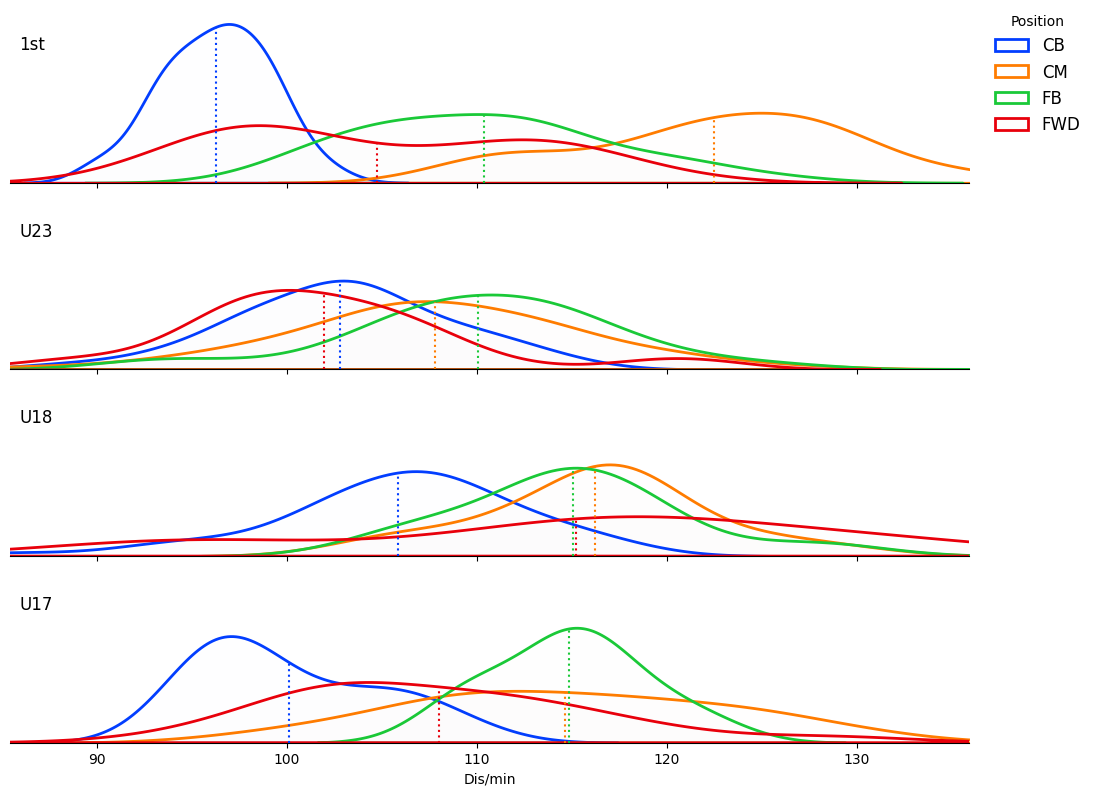

In [21]:
g = sns.FacetGrid(df, row="team", hue="position", row_order=["1st", "U23", "U18", "U17"], height=2, aspect=5)
g.map(sns.kdeplot, measure, bw_adjust=1, fill=True, alpha=.005, lw=2)


for i, ax in enumerate(g.axes.flat):
    ax.text(0.01, 0.8, g.row_names[i],
            fontsize=12, transform = ax.transAxes)
    ax.set_xlim(min(df[measure]), max(df[measure]))

# add mean lines        
for i, ax in enumerate(g.axes.flat):
    for j, collection in enumerate(ax.collections):

        # Mean required to calulate x position of mean line
        df_p = df[(df["position"] == g.hue_names[j]) & (df["team"] == g.row_names[i])]
        mean = df_p[measure].mean()
        stdv = np.std(df_p[measure])

        # vertices need to have y=0 coords filtered out for interp to work
        vertices = collection.get_paths()[0].vertices
        vertices = vertices[vertices.T[1] > 0]

        # bubble sort to reduce risk of stack overflow?
        x_coords, y_coords = bubblesort_by_x(vertices.T[0], vertices.T[1])
        mean_height = np.interp(mean, x_coords, y_coords)
        stdm_height = np.interp(mean - stdv, x_coords, y_coords)
        stdp_height = np.interp(mean + stdv, x_coords, y_coords)

        ax.vlines(mean,0,mean_height, ls=":", colors=sns.color_palette("bright")[j])
        # ax.fill_between(x_coords, 0, y_coords, where=(mean - stdv <= x_coords) & (x_coords <= mean + stdv), interpolate=False, facecolor=sns.color_palette("bright")[j], alpha=0.2)

        # ax.vlines(mean - stdv,0,stdm_height, ls=":", colors=sns.color_palette("bright")[j])
        # ax.vlines(mean + stdv,0,stdp_height, ls=":", colors=sns.color_palette("bright")[j])
        
        
    
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=False, left=True)
g.add_legend(title="Position", loc="upper right", fontsize=12)
g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)







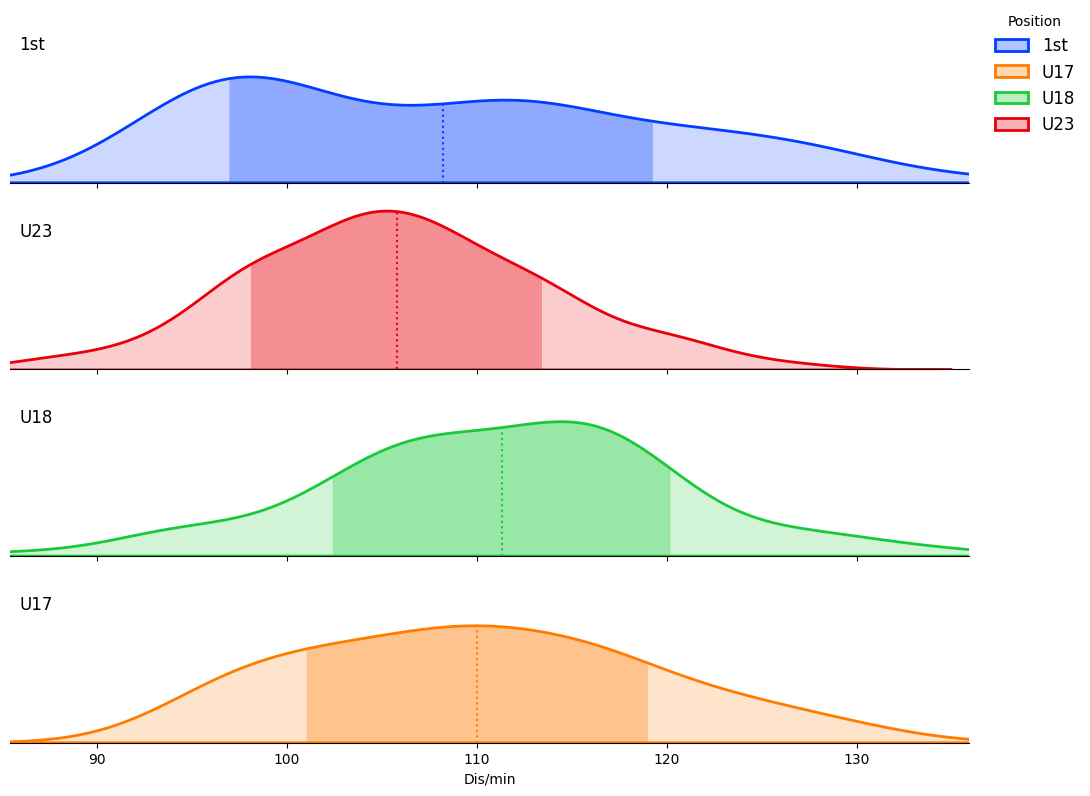

In [28]:
g = sns.FacetGrid(df, row="team", hue="team", row_order=["1st", "U23", "U18", "U17"], height=2, aspect=5)
g.map(sns.kdeplot, measure, bw_adjust=1, fill=True, alpha=.2, lw=2)


for i, ax in enumerate(g.axes.flat):
    ax.text(0.01, 0.8, g.row_names[i],
            fontsize=12, transform = ax.transAxes)
    ax.set_xlim(min(df[measure]), max(df[measure]))

# add mean lines        
for i, ax in enumerate(g.axes.flat):
    for j, collection in enumerate(ax.collections):

        # Mean required to calulate x position of mean line
        df_p = df[(df["team"] == g.row_names[i])]
        mean = df_p[measure].mean()
        stdv = np.std(df_p[measure])
        
        # vertices need to have y=0 coords filtered out for interp to work
        vertices = collection.get_paths()[0].vertices
        vertices = vertices[vertices.T[1] > 0]

        # As row order has been changed, face color needs to be indexced from collection and not theme
        face_color = collection.get_facecolor()[j]
        face_color[3] *= 1.5
        R,G,B,A = face_color
        # bubble sort to reduce risk of stack overflow?
        x_coords, y_coords = bubblesort_by_x(vertices.T[0], vertices.T[1])
        mean_height = np.interp(mean, x_coords, y_coords)
        

        ax.fill_between(x_coords, 0, y_coords, where=(mean - stdv <= x_coords) & (x_coords <= mean + stdv), interpolate=False, facecolor=face_color)
        
        ax.vlines(mean,0,mean_height, ls=":", colors=[R,G,B, 1])
        
        # stdm_height = np.interp(mean - stdv, x_coords, y_coords)
        # stdp_height = np.interp(mean + stdv, x_coords, y_coords)
        # ax.vlines(mean - stdv,0,stdm_height, ls=":", colors=sns.color_palette("bright")[j])
        # ax.vlines(mean + stdv,0,stdp_height, ls=":", colors=sns.color_palette("bright")[j])
        
        
    
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=False, left=True)
g.add_legend(title="Position", loc="upper right", fontsize=12)
g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)


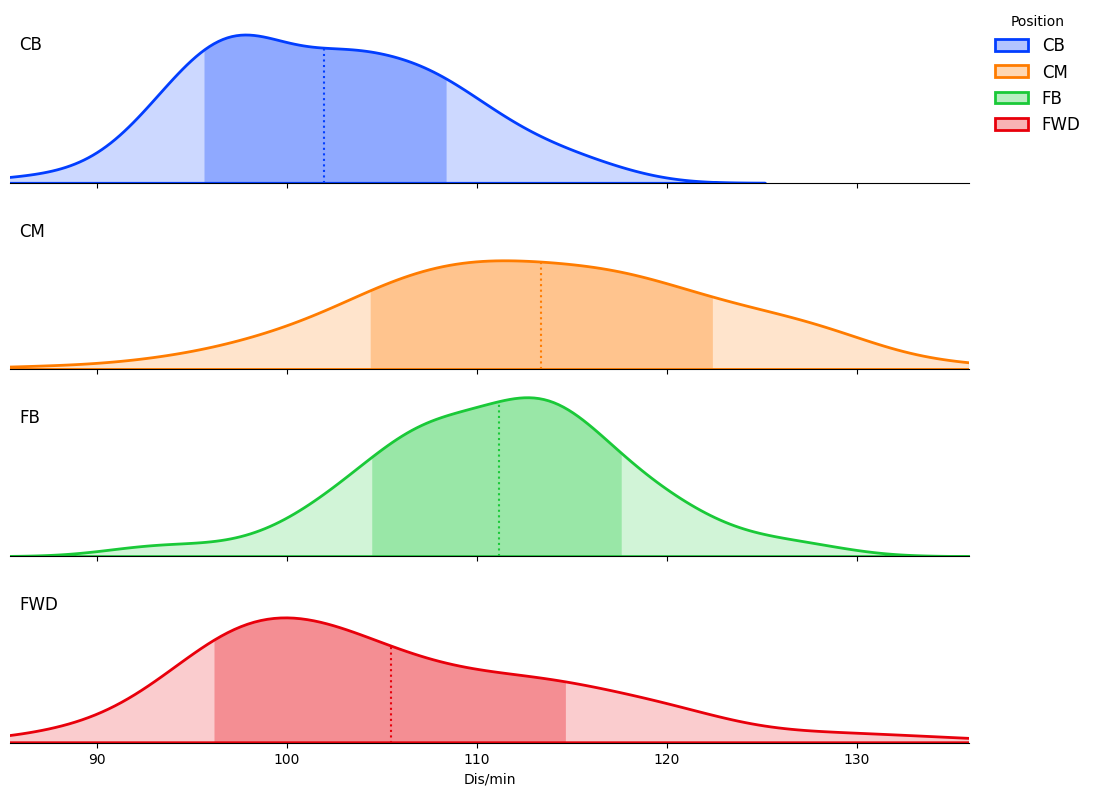

In [23]:
g = sns.FacetGrid(df, row="position", hue="position", height=2, aspect=5)
g.map(sns.kdeplot, measure, bw_adjust=1, fill=True, alpha=.2, lw=2)


for i, ax in enumerate(g.axes.flat):
    ax.text(0.01, 0.8, g.row_names[i],
            fontsize=12, transform = ax.transAxes)
    ax.set_xlim(min(df[measure]), max(df[measure]))

# add mean lines        
for i, ax in enumerate(g.axes.flat):
    for j, collection in enumerate(ax.collections):

        # Mean required to calulate x position of mean line
        df_p = df[ (df["position"] == g.row_names[i])]
        mean = df_p[measure].mean()
        stdv = np.std(df_p[measure])
        
        # vertices need to have y=0 coords filtered out for interp to work
        vertices = collection.get_paths()[0].vertices
        vertices = vertices[vertices.T[1] > 0]

        # As row order has been changed, face color needs to be indexced from collection and not theme
        face_color = collection.get_facecolor()[j]
        face_color[3] *= 1.5
        R,G,B,A = face_color
        # bubble sort to reduce risk of stack overflow?
        x_coords, y_coords = bubblesort_by_x(vertices.T[0], vertices.T[1])
        mean_height = np.interp(mean, x_coords, y_coords)
        stdm_height = np.interp(mean - stdv, x_coords, y_coords)
        stdp_height = np.interp(mean + stdv, x_coords, y_coords)

        ax.fill_between(x_coords, 0, y_coords, where=(mean - stdv <= x_coords) & (x_coords <= mean + stdv), interpolate=False, facecolor=face_color)
        
        ax.vlines(mean,0,mean_height, ls=":", colors=[R,G,B, 1])

        # ax.vlines(mean - stdv,0,stdm_height, ls=":", colors=sns.color_palette("bright")[j])
        # ax.vlines(mean + stdv,0,stdp_height, ls=":", colors=sns.color_palette("bright")[j])
        
        
    
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=False, left=True)
g.add_legend(title="Position", loc="upper right", fontsize=12)
g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)

mean: 100.13255384615385
height: 0.06177161238650932


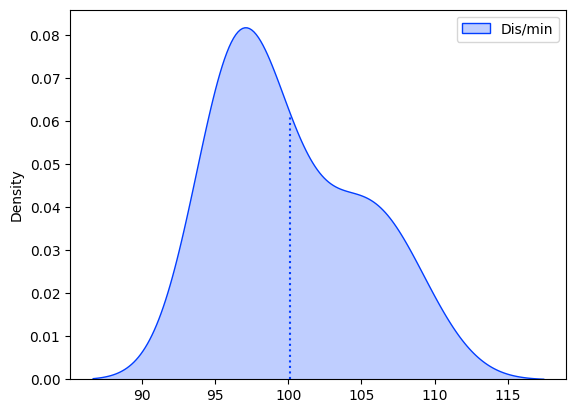

In [12]:
df_p = df[(df["position"] == "CB") & (df["team"] == "U17")]

mean = df_p[measure].mean()
print(f"mean: {mean}")
g = sns.kdeplot(data=df_p, fill=True)

vertices = g.collections[0].get_paths()[0].vertices

vertices = vertices[vertices.T[1] > 0]

# Order x axis
x_coords, y_coords = bubblesort_by_x(vertices.T[0], vertices.T[1])

height = np.interp(mean, x_coords, y_coords)

height1 = interpolate_2D_array(vertices, mean)

print(f"height: {height}")
# print(f"height2: {height2}")
g.vlines(mean,0,height, ls=":")

hi


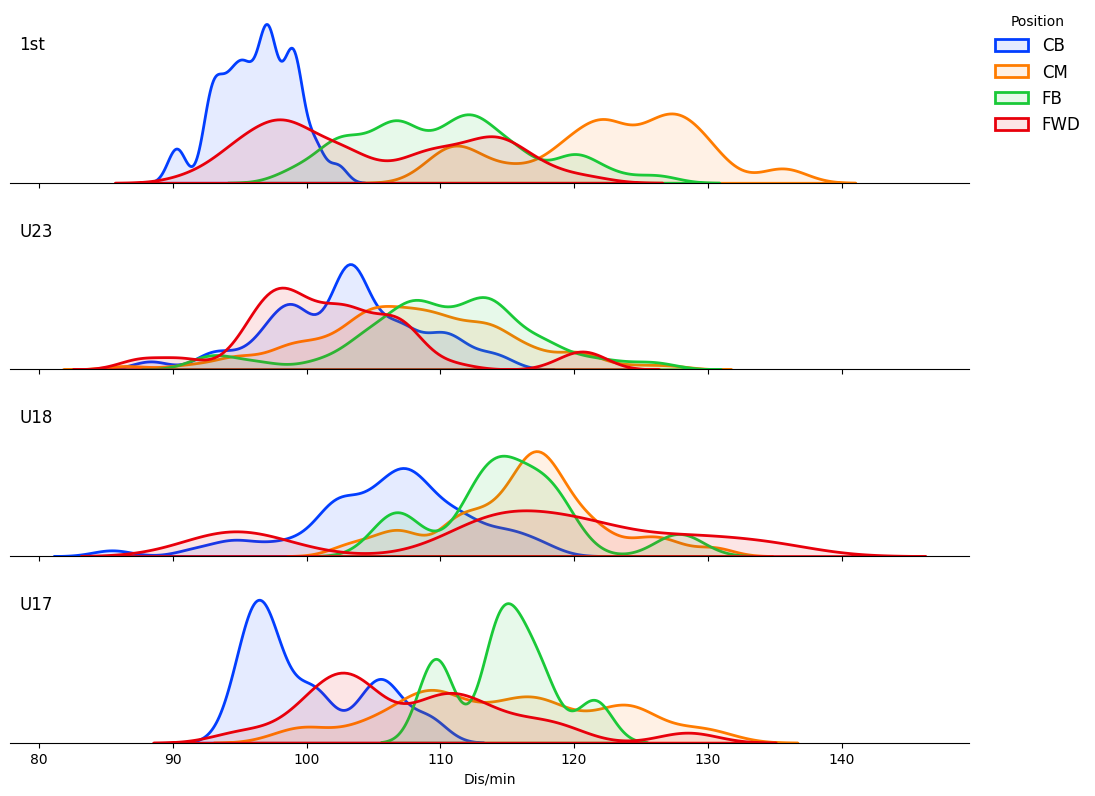

In [13]:
g = sns.FacetGrid(df, row="team", hue="position", row_order=["1st", "U23", "U18", "U17"], height=2, aspect=5)
g.map(sns.kdeplot, measure, bw_adjust=0.5, fill=True, alpha=.1, lw=2)

for i, ax in enumerate(g.axes.flat):
    ax.text(0.01, 0.8, g.row_names[i],
            fontsize=12, transform = ax.transAxes)
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=False, left=True)
g.add_legend(title="Position", loc="upper right", fontsize=12)
g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)
print("hi")


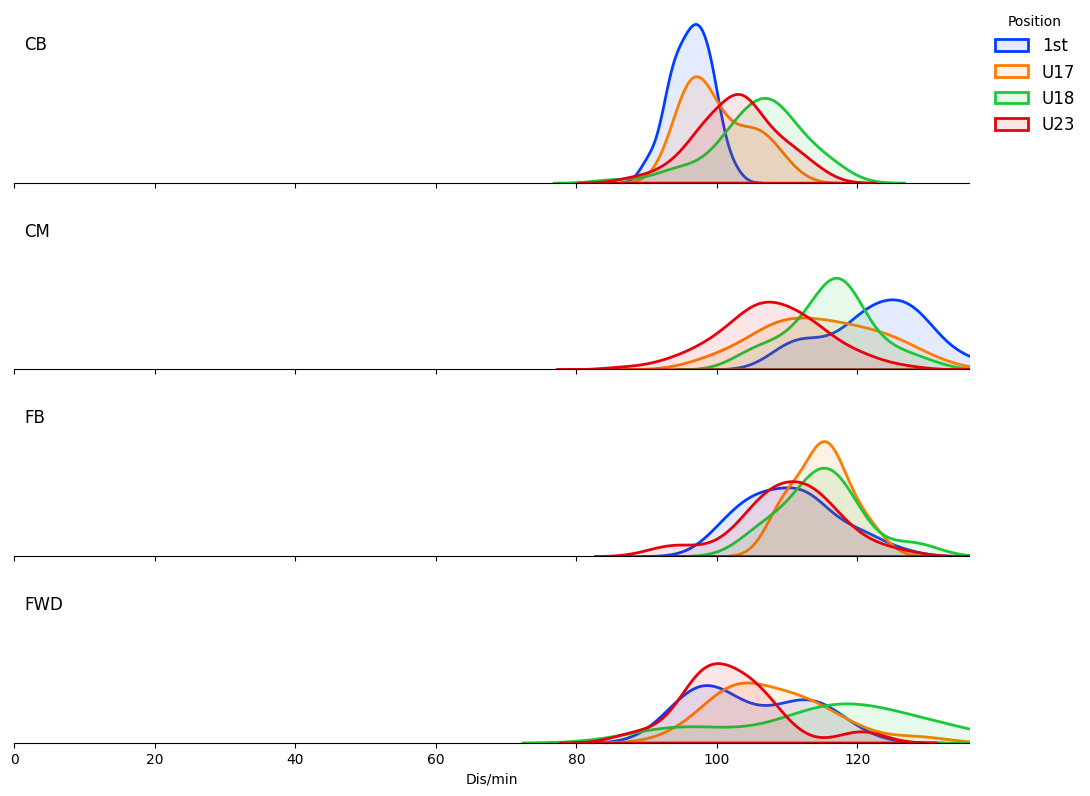

In [14]:
g = sns.FacetGrid(df, row="position", hue="team", height=2, aspect=5)
g.map(sns.kdeplot, measure, fill=True, alpha=.1, lw=2)


for i, ax in enumerate(g.axes.flat):
    ax.text(0.01, 0.8, g.row_names[i],
            fontsize=12, transform = ax.transAxes)
    ax.set_xlim(0, max(df[measure]))
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.01)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=False, left=True)

g.add_legend(title="Position", loc="upper right", fontsize=12)
g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)